# Predictive Black-Litterman CVaR Portfolio Optimization

The objective of the present guide is to illustrate how to implement a predictive Black-Litterman CVaR portfolio optimization using the PyFinPO library. This methodology follows a similar structure to the one detailed in [Tutorial 1 - PyFinPO User Guide](Tutorial%201%20-%20PyFinPO%20User%20Guide.ipynb), and aims to provide a practical case study example which can be extended to other types of portfolio optimization models, objectives, constraints, input datasets and predictive models as well.

## Library Import

In [11]:
import sys

sys.path.append('/Users/alvarosanchez/Documents/Projects/personal-projects/pyfinpo')

## 0) Getting the data

### Security Prices

In [12]:
import yfinance as yf

tickers = ["AAPL", "META", "AMZN", "NFLX", "GOOG", "GS", "JPM", "MS", "C", "MSFT", "PFE", "TSLA", "UNH", "XOM"]
ohlc = yf.download(tickers, start="2015-01-01")
prices = ohlc["Adj Close"].dropna(how="all")
prices

[*********************100%***********************]  14 of 14 completed


Ticker,AAPL,AMZN,C,GOOG,GS,JPM,META,MS,MSFT,NFLX,PFE,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,
2015-01-02 00:00:00+00:00,24.347172,15.426000,41.534031,26.104546,160.355621,47.709976,78.214500,29.519684,40.152481,49.848572,20.041164,14.620667,86.892982,60.042534
2015-01-05 00:00:00+00:00,23.661276,15.109500,40.225079,25.560379,155.348892,46.228802,76.958290,28.596958,39.783253,47.311428,19.932419,14.006000,85.461700,58.399662
2015-01-06 00:00:00+00:00,23.663502,14.764500,38.808975,24.967966,152.206284,45.030140,75.921410,27.773369,39.199337,46.501431,20.098738,14.085333,85.289268,58.089199
2015-01-07 00:00:00+00:00,23.995319,14.921000,39.168747,24.925188,154.474533,45.098858,75.921410,28.169897,39.697369,46.742859,20.373796,14.063333,86.160095,58.677780
2015-01-08 00:00:00+00:00,24.917265,15.023000,39.758152,25.003778,156.940826,46.106659,77.945312,28.589329,40.865192,47.779999,20.789593,14.041333,90.272812,59.654465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-18 00:00:00+00:00,228.020004,201.699997,69.000000,176.800003,587.989990,245.029999,554.400024,133.779999,414.929474,847.049988,24.860001,338.739990,589.650024,120.309998
2024-11-19 00:00:00+00:00,228.279999,204.610001,68.599998,179.580002,581.380005,243.089996,561.090027,132.240005,416.955414,871.320007,25.100000,346.000000,577.000000,118.629997
2024-11-20 00:00:00+00:00,229.000000,202.880005,68.279999,177.330002,581.929993,240.779999,565.520020,131.690002,414.659973,883.849976,24.940001,342.029999,600.500000,120.320000


### Market Prices (SPY)

In [13]:
market_prices = yf.download("SPY", start="2015-01-01")["Adj Close"]
market_prices

[*********************100%***********************]  1 of 1 completed


Ticker,SPY
Date,
2015-01-02 00:00:00+00:00,173.173752
2015-01-05 00:00:00+00:00,170.046310
2015-01-06 00:00:00+00:00,168.444641
2015-01-07 00:00:00+00:00,170.543640
2015-01-08 00:00:00+00:00,173.569977
...,...
2024-11-18 00:00:00+00:00,588.150024
2024-11-19 00:00:00+00:00,590.299988
2024-11-20 00:00:00+00:00,590.500000


### Security Market Caps

In [14]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'AAPL': 3474668650496,
 'META': 1411543334912,
 'AMZN': 2072716771328,
 'NFLX': 383767478272,
 'GOOG': 2026840522752,
 'GS': 189218684928,
 'JPM': 699752775680,
 'MS': 216990973952,
 'C': 132085596160,
 'MSFT': 3100344844288,
 'PFE': 145358290944,
 'TSLA': 1131738693632,
 'UNH': 543768215552,
 'XOM': 535277993984}

## 1) Input Estimates

### 1.1) Prior Estimates

We first compute the Covariance Matrix of the input dataset of prices. We chose the ``ledoit_wolf()`` Covariance Shrinkage method as estimator for the covariance matrix as is one of the most stable choices according to research [[1](https://pyportfolioopt.readthedocs.io/en/latest/RiskModels.html#shrinkage-estimators)].

#### (Prior) Covariance Matrix Estimation

<Axes: >

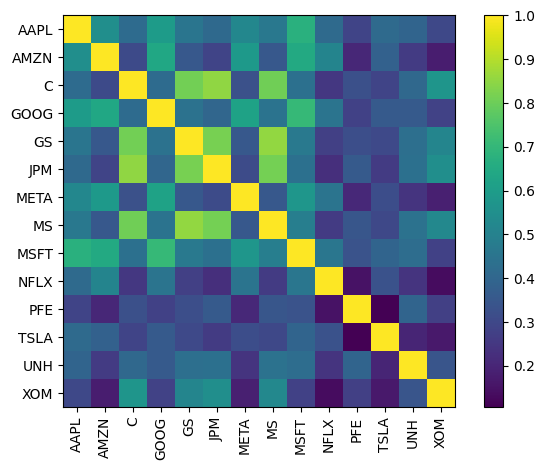

In [15]:
from pyfinpo.input_estimates import risk_models
from pyfinpo.visualization import po_plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
po_plotting.plot_covariance(S, plot_correlation=True)

#### (Prior) Expected Returns Estimation

We have several options available to estimate the expected returns (prior to any market views).

- A first option would be to use any of the expected return models available in the PyPO library (mean historical return, exponentially weighted mean historical return, or capm). 

- However, if we don't have a reliable forecasting method for expected returns, a second option would be to Compute the prior estimate of returns implied by the market weights. In other words, given each asset's contribution to the risk of the market portfolio, we will calculate how much we are expecting to be compensated. For that, we just need to use the ``black_litterman.market_implied_prior_returns()`` method.

In the absence of good forecasting models, let's take the second path and calculate the market implied expected returns. What we do is first calculate the market implied risk aversion parameter ($\delta$), and then compute the prior estimate of returns using the risk aversion and the previously estimated covariance matrix.

In [17]:
from pyfinpo.input_estimates.robust_models import black_litterman_rm

delta_risk_aversion = black_litterman_rm.market_implied_risk_aversion(market_prices)['SPY']
delta_risk_aversion

np.float64(3.8708874576936725)

Ticker
AAPL    0.237604
AMZN    0.254665
C       0.186131
GOOG    0.232107
GS      0.175279
JPM     0.156508
META    0.269401
MS      0.191101
MSFT    0.235194
NFLX    0.248715
PFE     0.094726
TSLA    0.326731
UNH     0.132513
XOM     0.117449
dtype: float64


<Axes: ylabel='Ticker'>

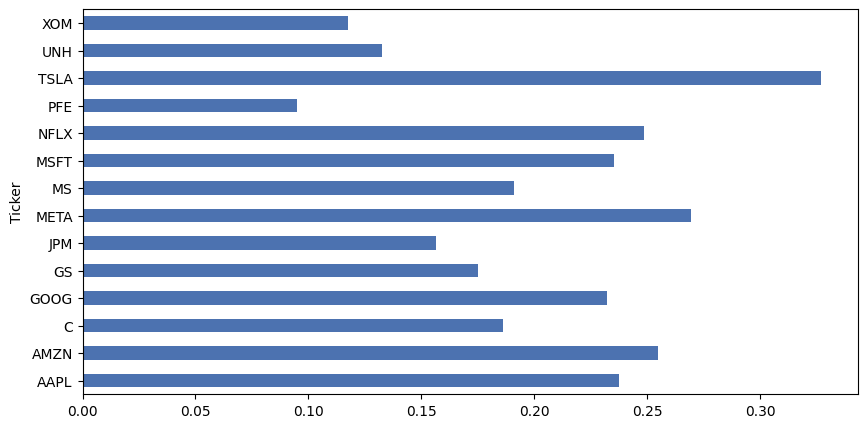

In [18]:
market_prior = black_litterman_rm.market_implied_prior_returns(mcaps, delta_risk_aversion, S)
print(market_prior)
market_prior.plot.barh(figsize=(10,5))

### 1.2) Views

Now that we have the prior estimates for the covariance matrix and the expected returns, we can create the inputs to incorporate our market views into the model. There are 2 main inputs to provide here: i) our market views (either in relative or absolute terms), and ii) our confidence in the views.

#### Views Matrix (V)

In the Black-Litterman model, the views can be expressed in **relative terms** via 2 matrices:
 - ``Q``-> the vector that specifies the magnitude of each view
 - ``P`` -> picking matrix, which maps the views (Q vector) to each of the assets they belong to

Alternatively, we can also provide our views in **absolute terms** by providing a dictionary with a return estimate for each asset:

In [19]:
viewdict = {
    "AAPL": 0.05,
    "AMZN": 0.1,
    "C": 0.03,
    "GOOG": 0.04,
    "GS": 0.03,
    "JPM": 0.05,
    "META": 0.07,
    "MS": 0.04,
    "MSFT": 0.05,
    "NFLX": -0.03,
    "PFE": -0.01,
    "TSLA": 0.01,
    "UNH": 0.00,
    "XOM": 0.02
}
len(viewdict)

14

#### Uncentainty Matrix ($\Omega$)

Two ways are proposed to construct the uncertainty matrix, to express more or less confidence in the provided views.

##### A) Idzorek's method (% of confidence)

The first one is using the Idzorek's method, which simply allows to specify a vector with the percentage of confidence on each view:

In [20]:
uncertainty_matrix = [
    0.7,
    0.6,
    0.5,
    0.8, # Quite confident in GOOG view
    0.2,
    0.5,
    0.7,
    0.5, 
    0.5,
    0.5,
    0.2,
    0.1, # Not confident in TSLA view
    0.3,
    0.2
]
len(uncertainty_matrix)

14

In [21]:
from pyfinpo.input_estimates.robust_models import BlackLittermanModel

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=uncertainty_matrix)
     

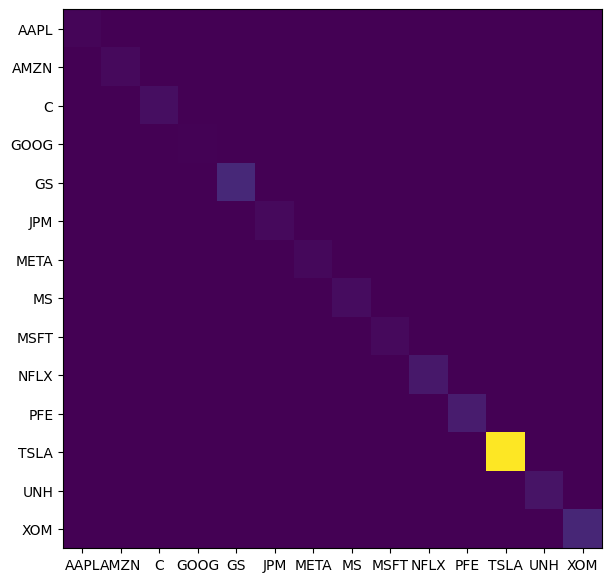

In [23]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [24]:
np.diag(bl.omega)

array([0.00175397, 0.00359194, 0.00540976, 0.00101568, 0.01676258,
       0.00378553, 0.00301863, 0.00494484, 0.00371858, 0.00953906,
       0.01089167, 0.14569693, 0.00792013, 0.01560363])

##### B) Confidence Interval Method

An alternative to specifying a percentage of confidence (which can be somewhat arbitrary), would be to specify the 1 standard deviation price confidence interval for each view:

In [25]:
uncertainty_intervals = [
    (0.03,0.07), #AAPL
    (0.06,0.13), #AMZN
    (0.01,0.05), #C
    (0.03,0.09), #GOOG
    (0.00,0.05), #GS
    (0.04,0.06), #JPM
    (0.01,0.09), #META
    (0.02,0.07), #MS
    (0.01,0.09), #MSFT
    (-0.04,0.01), #NFLX
    (-0.03,0.03), #PFE
    (-0.02,0.03), #TSLA
    (-0.05,0.05), #UNH
    (0.0,0.03) #XOM
]
len(uncertainty_intervals)

14

In [26]:
variances = []
for lb, ub in uncertainty_intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.0004000000000000002, 0.0012250000000000002, 0.0004, 0.0009, 0.0006250000000000001, 9.999999999999996e-05, 0.0016, 0.0006250000000000001, 0.0016, 0.0006250000000000001, 0.0009, 0.0006250000000000001, 0.0025000000000000005, 0.000225]


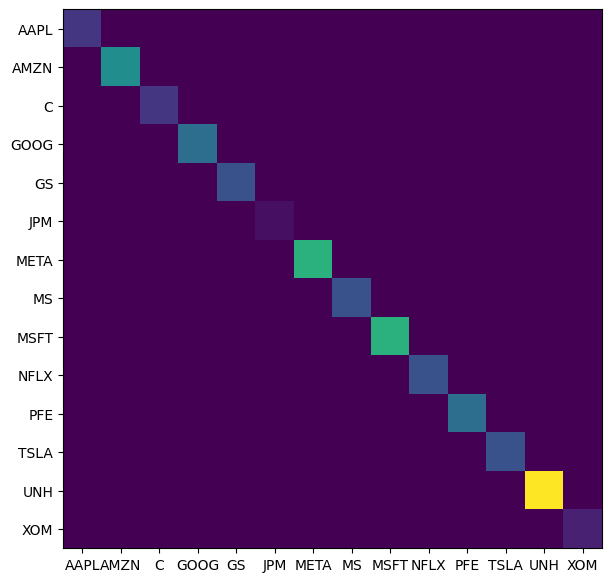

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(viewdict)))
ax.set_yticks(np.arange(len(viewdict)))

ax.set_xticklabels(viewdict.keys())
ax.set_yticklabels(viewdict.keys())
plt.show()

### 1.3) Posterior Estimates

Having computed the previous inputs (market cap, covariance matrix, risk aversion, views and uncertainty), we can plug them in the Black-Litterman model and generate an posterior estimate for returns and covariance matrix:

In [28]:
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta_risk_aversion, absolute_views=viewdict, omega=omega)

#### Posterior Estimate of Returns

In [29]:
mu_bl = bl.bl_returns()
mu_bl

Ticker
AAPL    0.054283
AMZN    0.089008
C       0.033966
GOOG    0.050973
GS      0.034269
JPM     0.047861
META    0.073306
MS      0.041407
MSFT    0.060222
NFLX   -0.020987
PFE    -0.000629
TSLA    0.015475
UNH     0.013363
XOM     0.020531
dtype: float64

In [30]:
import pandas as pd

mu_df = pd.DataFrame([market_prior, mu_bl, pd.Series(viewdict)], index=["Prior", "Posterior", "Views"]).T
mu_df

,Prior,Posterior,Views
AAPL,0.237604,0.054283,0.05
AMZN,0.254665,0.089008,0.10
C,0.186131,0.033966,0.03
GOOG,0.232107,0.050973,0.04
GS,0.175279,0.034269,0.03
JPM,0.156508,0.047861,0.05
META,0.269401,0.073306,0.07
MS,0.191101,0.041407,0.04
MSFT,0.235194,0.060222,0.05
NFLX,0.248715,-0.020987,-0.03


<Axes: >

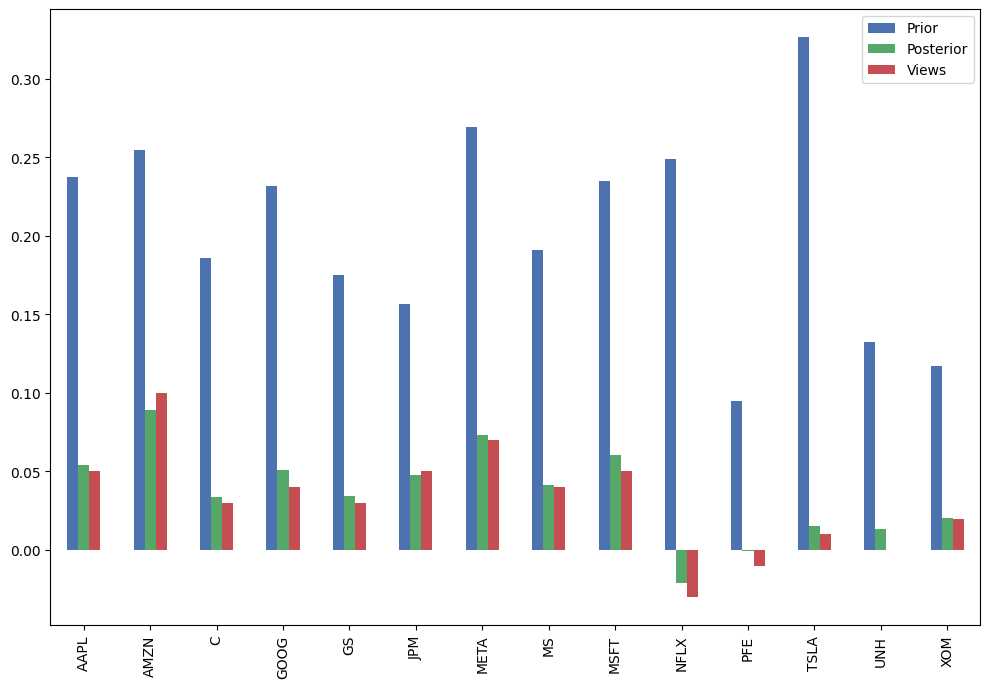

In [31]:
mu_df.plot.bar(figsize=(12,8))

We can observe that the posterior typically falls between the prior and the views. This reinforces the idea that the Black-Litterman (BL) method operates as a Bayesian weighted average of the prior and the views, with the weights influenced by the level of confidence.

#### Posterior Covariance Estimate

<Axes: >

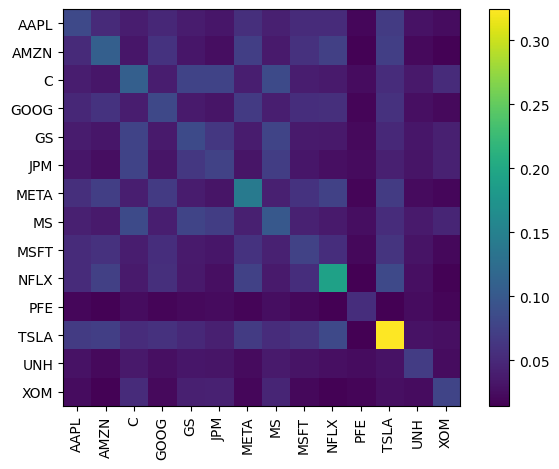

In [32]:
S_bl = bl.bl_cov()
po_plotting.plot_covariance(S_bl)

## 2) Portfolio Mean-CVaR Optimization

Once the Black-Litterman input estimates have been calculated, we are in a position to compute the actual portfolio optimization.

In [33]:
from pyfinpo.portfolio_optimization import po_models, po_objective_functions, po_optimizers

### 2.1) Portfolio Optimization Model

The selected portfolio optimization model to combine with Black-Litterman has been Mean-CVaR optimization. The reason is that according to research, choosing Conditional Value at Risk (CVaR) portfolio optimization over mean-variance portfolio optimization offers several advantages, particularly in the context of risk management and the nature of financial returns:
- **Capturing on Asymmetry of Returns**
    - Financial returns often exhibit asymmetry, where losses are typically more severe than gains. CVaR accounts for this asymmetry by focusing on the average of the worst-case scenarios, thus providing a clearer picture of potential losses compared to mean-variance optimization, which assumes a normal distribution of returns. This characteristic allows for better risk assessment in portfolios that may not conform to traditional assumptions.

- **Capturing Tail Risk**
    - CVaR specifically addresses tail risk, i.e. the risk of extreme losses that occur in the lower tail of the return distribution. Unlike mean-variance optimization, which primarily considers variance as a measure of risk, CVaR provides a more comprehensive view by estimating the expected loss given that a loss has exceeded a certain threshold (Value at Risk, or VaR). This makes CVaR particularly valuable for investors concerned about significant downturns.

- **Robustness to Non-normal Distributions**
    - While mean-variance optimization relies on the assumption of normally distributed returns, CVaR does not have this limitation. It can be applied to a variety of return distributions, including those that are skewed or have fat tails, making it more robust in real-world applications where asset returns often deviate from normality.

- **Linear Programming Compatibility**
    - CVaR can be formulated using linear programming techniques, which simplifies the optimization process and allows for handling larger portfolios and more complex constraints efficiently. This is beneficial for practitioners who need to optimize portfolios with multiple assets and varying risk profiles.

- **Enhanced Risk Measure**
    - CVaR is considered a coherent risk measure because it satisfies properties such as subadditivity and positive homogeneity. This means that diversifying a portfolio should not increase its risk, aligning with intuitive principles of risk management. In contrast, mean-variance optimization may lead to counterintuitive results in certain scenarios.

In [34]:
bl_mcvar_po = po_models.MeanCVaRPO(mu_bl, S_bl)

### 2.2) Portfolio Optimization Objectives & Constraints

To make the problem more realistic, we have also incorporated portfolio regularization as objective (forcing some degree of diversification by avoiding many zero weights), and we have added esg scores constraints to make sure our portfolio meets specific ESG requirements.

In [35]:
bl_mcvar_po.add_objective(po_objective_functions.L2_reg)

In [36]:
esg_scores = [0.3, 0.1, 0.5, 0.1, 0.4, 0.1, 0.9, 0.20, 0.1, 0.4, 0.1, 0.5, 0.9, 0.2]
portfolio_min_score = 0.5

bl_mcvar_po.add_constraint(lambda w: esg_scores @ w >= portfolio_min_score)

### 2.3) Portfolio Optimization Objective Function & Solver

Once the optimization problem is defined, we just need to call the method solver ``.max_sharpe()`` to calculate the optimal portfolio weights that maximize the sharpe ratio (ratio return to risk), in the context of Mean-CVaR optimization:

In [39]:
bl_mcvar_po.min_cvar()

OrderedDict([('AAPL', np.float64(0.0630694465968775)),
             ('AMZN', np.float64(0.0294712529862122)),
             ('C', np.float64(0.0976299567410198)),
             ('GOOG', np.float64(0.0309287116856891)),
             ('GS', np.float64(0.0800538870545933)),
             ('JPM', np.float64(0.0331618670751414)),
             ('META', np.float64(0.1577149223985937)),
             ('MS', np.float64(0.0502202826567939)),
             ('MSFT', np.float64(0.0323031248146157)),
             ('NFLX', np.float64(0.0768872464021416)),
             ('PFE', np.float64(0.0492039035368131)),
             ('TSLA', np.float64(0.0921790139503894)),
             ('UNH', np.float64(0.1606693968176769)),
             ('XOM', np.float64(0.046506987283442))])

## 3) Portfolio Performance

In [45]:
bl_mcvar_po.portfolio_performance(verbose=True)

Expected annual return: 3.4%
Conditional Value at Risk: -2.19%


(np.float64(0.03373988855744729), np.float64(-0.021900845785880457))

## 4) Portfolio Post-Processing

### 4.1) Portfolio (Tidy) Weights

In [42]:
weights = bl_mcvar_po.clean_weights()
weights

OrderedDict([('AAPL', np.float64(0.06307)),
             ('AMZN', np.float64(0.02947)),
             ('C', np.float64(0.09763)),
             ('GOOG', np.float64(0.03093)),
             ('GS', np.float64(0.08005)),
             ('JPM', np.float64(0.03316)),
             ('META', np.float64(0.15771)),
             ('MS', np.float64(0.05022)),
             ('MSFT', np.float64(0.0323)),
             ('NFLX', np.float64(0.07689)),
             ('PFE', np.float64(0.0492)),
             ('TSLA', np.float64(0.09218)),
             ('UNH', np.float64(0.16067)),
             ('XOM', np.float64(0.04651))])

<Axes: >

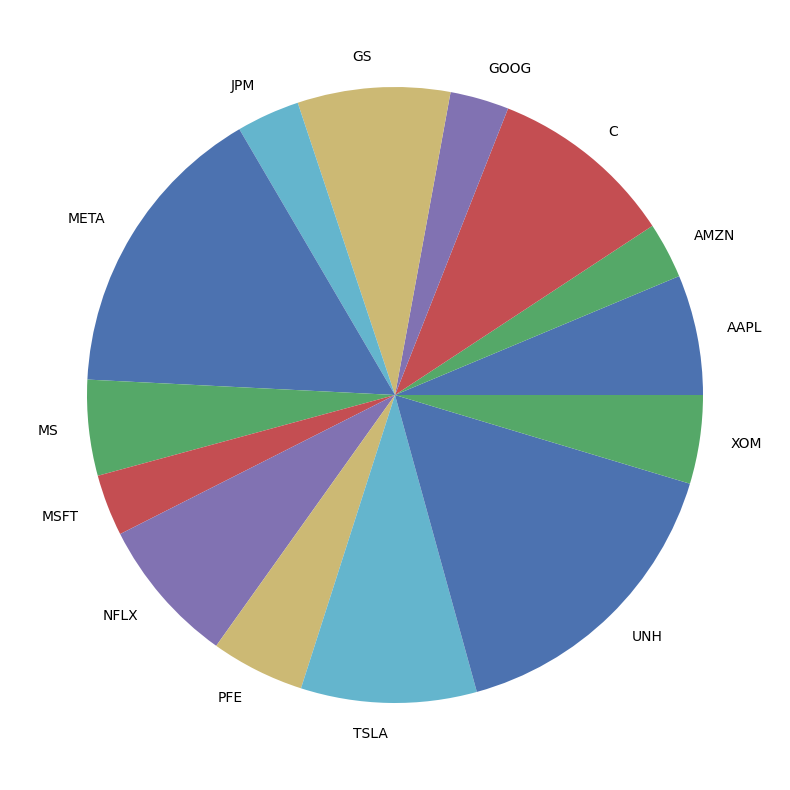

In [43]:
import pandas as pd

pd.Series(weights).plot.pie(figsize=(10,10))

### 4.2) Portfolio Discrete Allocation

In [44]:
from pyfinpo.utils import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $23.57


/Users/alvarosanchez/Documents/Projects/personal-projects/pyfinpo/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


{'AAPL': np.int64(5),
 'AMZN': np.int64(3),
 'C': np.int64(28),
 'GOOG': np.int64(4),
 'GS': np.int64(3),
 'JPM': np.int64(3),
 'META': np.int64(5),
 'MS': np.int64(7),
 'MSFT': np.int64(2),
 'NFLX': np.int64(2),
 'PFE': np.int64(39),
 'TSLA': np.int64(5),
 'UNH': np.int64(5),
 'XOM': np.int64(8)}